In [ ]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth, output_dim):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

In [3]:
import sys
sys.path.append('../utils/')

In [4]:
from Bias_Variance_Estimator import estimate_bias_variance_0_1

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# -----------------------------
# 1. Load dataset (digits 8x8 images, 10 classes)
# -----------------------------
digits = load_digits()
X = digits.data.astype(np.float32)   # shape (1797, 64)
y = digits.target.astype(np.int64)

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
depth_sizes = [1,2,4,8,16,32,64]
results=[]
for d in depth_sizes:
    print(f"training with depth size {d}")
    avg_bias, avg_var, avg_exp_loss, empirical_01_loss,avg_train_loss, _ =estimate_bias_variance_0_1(
        model_class=MLPClassifier,
        loss_fn = nn.CrossEntropyLoss(),
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_kwargs={'input_dim': X_train.shape[1],'hidden_dim':128,'depth':d,'out_dim':10,'use_batchnorm':True},
        num_models=20,
        max_epochs=500,
        patience=500,
        lr=0.001,
    )
    results.append({
            'depth': d,
            'bias': avg_bias,
            'variance': avg_var,
            'avg_exp_loss': avg_exp_loss,
            'empirical_01_loss': empirical_01_loss,
            'avg_train_loss':avg_train_loss
        })

training with depth size 1


NameError: name 'MLPClassifier' is not defined

In [ ]:
depth_sizes

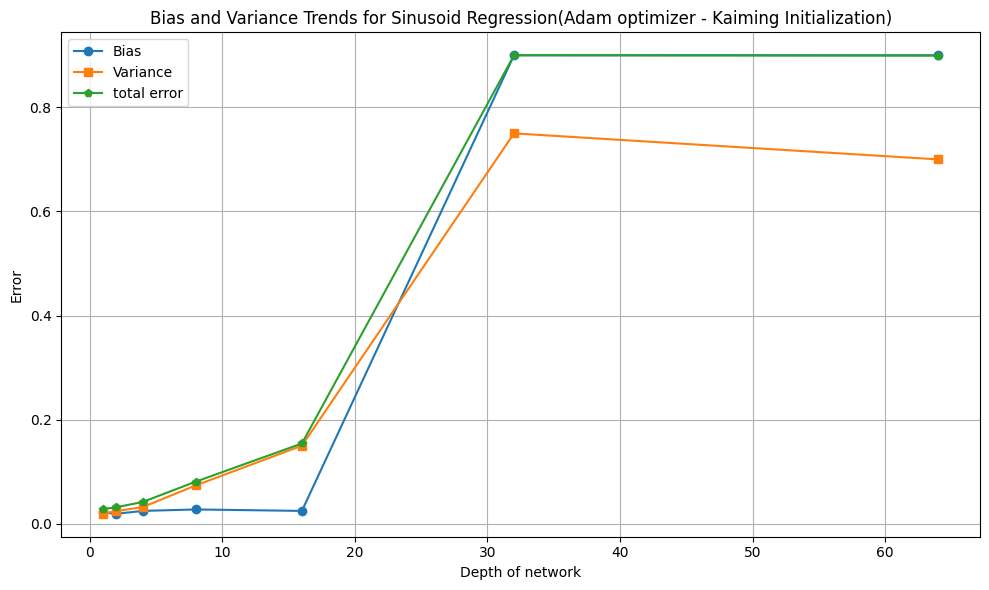

In [17]:
bias_values = [res['bias'] for res in results]
variance_values = [res['variance'] for res in results]
error_values = [res['avg_exp_loss'] for res in results]
    
plt.figure(figsize=(10, 6))
plt.plot(depth_sizes, bias_values, marker='o', label='Bias')
plt.plot(depth_sizes, variance_values, marker='s', label='Variance')
plt.plot(depth_sizes, error_values, marker='p', label='total error')
    
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(Adam optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [2]:
# import torch
import torch.nn as nn


class MLPHeInit(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth, out_dim=1,use_batchnorm=False):
        super(MLPHeInit,self).__init__()
        layers = []

        for i in range(depth):
            in_dim = input_dim if i == 0 else hidden_dim
            layers.append(nn.Linear(in_dim, hidden_dim))
            
            # He initialization
            nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
            nn.init.zeros_(layers[-1].bias)

            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, out_dim))
        nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='linear')
        nn.init.zeros_(layers[-1].bias)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [8]:
depth_sizes = [1,2,4,8,16,32,64]
he_results=[]
for d in depth_sizes:
    print(f"training with depth size {d}")
    avg_bias, avg_var, avg_exp_loss, empirical_01_loss,avg_train_loss, test_loss,_ = estimate_bias_variance_0_1(
        model_class=MLPHeInit,
        loss_fn = nn.CrossEntropyLoss(),
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_kwargs={'input_dim': X_train.shape[1],'hidden_dim':64,'depth':d,'out_dim':10,'use_batchnorm':True},
        num_models=30,
        max_epochs=500,
        patience=500,
        lr=0.001,
    )
    he_results.append({
            'depth': d,
            'bias': avg_bias,
            'variance': avg_var,
            'avg_exp_loss': avg_exp_loss,
            'empirical_01_loss': empirical_01_loss,
            'avg_train_loss':avg_train_loss
        })

training with depth size 1
Starting experiment with 30 models...

--- Training Model 1/30 ---


KeyboardInterrupt: 

In [12]:
depth_sizes

[1, 2, 4, 8, 16, 32, 64]

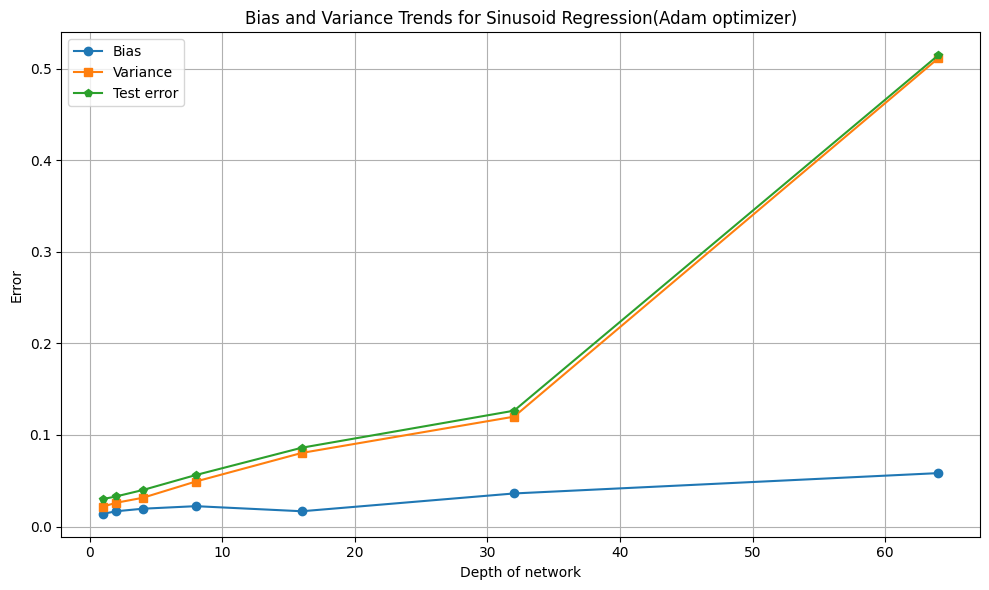

In [13]:
bias_values = [res['bias'] for res in he_results]
variance_values = [res['variance'] for res in he_results]
error_values = [res['avg_exp_loss'] for res in he_results]
    
plt.figure(figsize=(10, 6))
plt.plot(depth_sizes, bias_values, marker='o', label='Bias')
plt.plot(depth_sizes, variance_values, marker='s', label='Variance')
plt.plot(depth_sizes, error_values, marker='p', label='Test error')
    
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for 0-1 loss (digits dataset)')
plt.legend()
plt.grid(True)
plt.tight_layout()

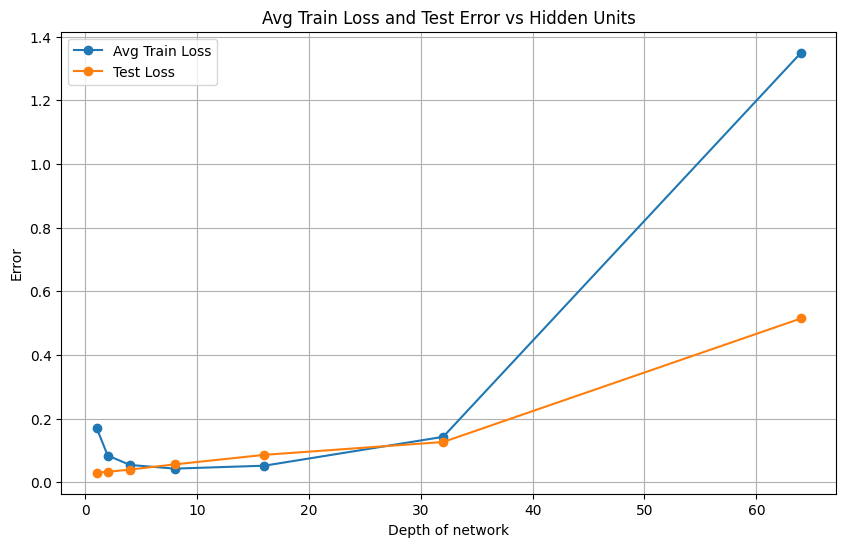

In [17]:
plt.figure(figsize=(10, 6))
avg_train_loss = [res['avg_train_loss'] for res in he_results]
plt.plot(depth_sizes, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(depth_sizes, error_values, marker='o', label='Test Loss')
# plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Avg Train Loss and Test Error vs Hidden Units')
plt.legend()
plt.grid(True)
plt.show()